# **Homework 2 - Word Sense Disambiguation** 

## Imports

In [97]:
# import stuffs
from src.data_module import WSD_DataModule
from src.hyperparameters import Hparams
from src.train import train_model
from src.model import WSD_Model
from src.utils import one_group_bar, plot_histogram, evaluation_pipeline

import torch
from torch import nn
from collections import Counter
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import wandb
from dataclasses import asdict
import pytorch_lightning as pl

# to have a better workflow using python notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    _ = pl.seed_everything(seed)
set_seed(1999)

Global seed set to 1999


## Look at the data! 👀

The first thing to do before starting a new deep learning project is to look at the data! Without a quality dataset there's no way of achieving good results. In fact, a good *pre-processing* pipeline is a necessary condition for a high-quality **WSD system**. In the present case, the given dataset is quite *clean* and does not required much work but anyway there's always room for improvement.
The significance of this aspect is frequently disregarded as WSD systems commonly depend on pre-parsed documents that have already been divided into sentences, tokenized, lemmatized, and POS-tagged (like in our dataset), but nothing should be taken for granted!

> In our approach to WSD, we employ a supervised method that involves training machine learning models on *sense-annotated* data. The first thing to do is indeed to create and define a **sense inventory**, that is the set of all possible senses for all the words involved in the task. The senses are *synsets* from ***WordNet*** and express the different meanings of a word. Therefore the engineering process of defining the correct candidate set of possible meanings remains central to the overall disambiguation process. Fortunately this work has already been done :)

We are going to address two different WSD approaches:
-   **fine-grained WSD**: the senses are the ones form WordNet and it aims to provide more precise and detailed sense distinctions.
-   **coarse-grained WSD**: where we cluster the similar senses of a polysemous word to obtain a smaller number of sense distinctions. This approach aims to provide a higher-level understanding of word meanings, focusing on more general sense categories.


### Sense inventory

After making some reasonings, the easiest thing to do for build the sense invenctory was to take all the senses stored in the '*coarse_fine_defs_map.json*' file provided to us. We made all the possible checks to see if all the senses annotated in *train/val/test* datasets were not excluded and that's fortunately the case. 

> Of course the built sense inventory doesn't cover all the possible senses of all the possible polysemous words. Therefore I also implemented the logic for handle cases where the senses for the word to disambiguate are not present. In few words, by not cheating, if at least one sense among the candidate ones of the particular sample is \<UNK\>, the sense prediction will be <UNK> and consequently wrong.

Saying that, there won't be these kind of problems when using *train/val/test* sets.

In [38]:
# TOTAL NUMBER OF SENSES for coarse-grained WSD
hparams = asdict(Hparams()) # instantiate hyperparamters file
d = json.load(open(hparams["prefix_path"]+hparams["sense_map"], "r"))
all_senses_list = list(d.keys()) # 2158
print(f"Length of sense inventory for coarse-grained WSD is {len(all_senses_list)}")

Length of sense inventory for coarse-grained WSD is 2158


In [39]:
# Since we are dealing with neural networks we need to encode the sense invectory and simply create a mapping between 
# coarse-grained senses and indices.

# let's build sense2id and id2sense map for coarse-grained senses
sense2id = {}
id2sense = {}

idx=0
for sense in all_senses_list:
    sense2id[sense] = idx
    id2sense[idx] = sense
    idx+=1

sense2id["<UNK>"] = idx
id2sense[idx] = "<UNK>"
    
json.dump(sense2id, open(hparams["prefix_path"]+"model/files/coarse_sense2id.json", "w"))
json.dump(id2sense, open(hparams["prefix_path"]+"model/files/coarse_id2sense.json", "w"))

In [4]:
data = WSD_DataModule(hparams)
data.setup()

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD
all_senses_train = []
for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_train.append(candidate)            
c_train = Counter(all_senses_train)
print(f"Total senses for train dataset: {len(c_train)}") # 1933

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD
all_senses_val = []
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_val.append(candidate)
c_val = Counter(all_senses_val)
print(f"Total senses for val dataset: {len(c_val)}") # 750

# TOTAL NUMBER OF TRAIN SENSES for coarse-grained WSD  
all_senses_test = []
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        for candidate in candidate_set:
            all_senses_test.append(candidate)
c_test = Counter(all_senses_test)
print(f"Total senses for test dataset: {len(c_test)}") # 781

100%|██████████| 225/225 [01:08<00:00,  3.29it/s]


Total senses for train dataset: 1933


100%|██████████| 17/17 [00:07<00:00,  2.19it/s]


Total senses for val dataset: 750


100%|██████████| 18/18 [00:07<00:00,  2.33it/s]

Total senses for test dataset: 781


In [5]:
# CHECK that all senses present in train/val/test are included in the SENSE INVENTORY
all_senses_list = [sense2id[e] for e in all_senses_list] # we encode the senses
i=0 
for s in list(c_train.keys()):
    if s not in all_senses_list:
        print(s)
        i+=1
assert i==0

i=0 
for s in list(c_val.keys()):
    if s not in all_senses_list:
        i+=1
assert i==0

i=0   
for s in list(c_test.keys()):
    if s not in all_senses_list:
        i+=1
assert i==0

> *Sense inventory* comprehend all our dataset coarse-grained senses! 

We do the same thing for **fine-grained** senses thanks to '*coarse_fine_defs_map.json*' file. The check we've done before it's now useless to perform since fine-grained senses are included in coarse-grained ones.

In [6]:
# let's build sense2id and id2sense map for fine-graned senses
d = json.load(open(hparams["prefix_path"]+hparams["sense_map"], "r"))
all_senses_list = [] # 4476
for k in d.keys():
    for fine_s in d[k]:
        all_senses_list.append(list(fine_s.keys())[0])
print(f"Length of sense inventory for fine-grained WSD is {len(all_senses_list)}")

sense2id = {}
id2sense = {}

idx=0
for sense in all_senses_list:
    sense2id[sense] = idx
    id2sense[idx] = sense
    idx+=1

sense2id["<UNK>"] = idx
id2sense[idx] = "<UNK>"
    
json.dump(sense2id, open(hparams["prefix_path"]+"model/files/fine_sense2id.json", "w"))
json.dump(id2sense, open(hparams["prefix_path"]+"model/files/fine_id2sense.json", "w"))

Length of sense inventory for fine-grained WSD is 4476


In [7]:
# Because of some approaches I'll develop later I need 
# to build a direct mapping between fine and coarse-grained (we already have the opposite mapping)

d = json.load(open(hparams["prefix_path"]+hparams["sense_map"], "r"))
fine2coarse = {}
for k in d.keys():
    for fine_s in d[k]:
        fine2coarse[list(fine_s.keys())[0]] = k

json.dump(fine2coarse, open(hparams["prefix_path"]+"model/files/fine2coarse.json", "w"))

### Data Analysis

> Let's make a quick quantitative analysis for facing what the dataset and the task is about.

**Number of candidates histogram**

100%|██████████| 18/18 [00:04<00:00,  3.97it/s]


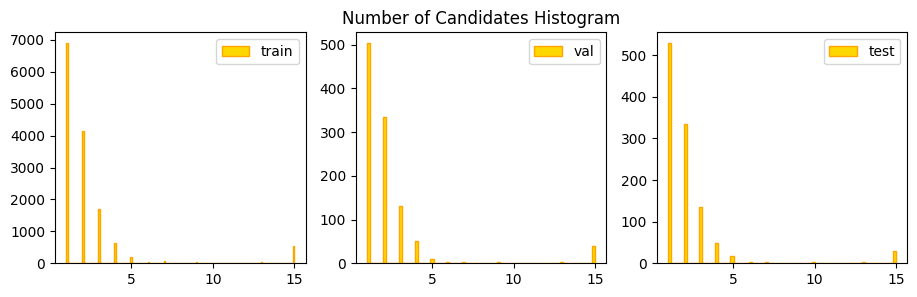

In [34]:
data = WSD_DataModule(hparams)
data.setup()
num_candidates = []

num_candidates_train = []
for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_train.append(len(candidate_set))
num_candidates.append(num_candidates_train)
        
num_candidates_val = []
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_val.append(len(candidate_set))
num_candidates.append(num_candidates_val)
        
num_candidates_test = []
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        num_candidates_test.append(len(candidate_set))
num_candidates.append(num_candidates_test)
    
plot_histogram(num_candidates, multiple=True, title="Number of Candidates Histogram")

> We can say for sure that the three splits represent the same data distribution (and this is already a good starting point). It's quite obvious that most of polysemous words have the range of possible meanings between 1 and 5. The only one coarse-grained sense is most likely case and this, of course, will help to increase my models performance (in the fine-grained case this doesn't stand anymore). <br> But the thing that immediately stands out is the presence of words with more than 5 possible "coarse" meanings! In particular the 15 case!

For this reason I'm going to save all candidate sets which have a length bigger than 5 for keeping track of my models performance on them (which should be the hardest cases!). 

In [50]:
# I want to compute and actually see which are the most difficult (theoretically) words to disambiguate
# (an example is 'hall', 'find', 'stone', 'bound', 'bore', 'found' etc.)
hard_words_to_disambiguate = []

for batch in tqdm(data.train_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) > 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))
for batch in tqdm(data.val_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) > 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))
for batch in tqdm(data.test_dataloader()):
    for candidate_set in batch["candidates"]:
        if len(candidate_set) > 5:
            candidate_set = [id2sense[e] for e in candidate_set]
            candidate_set.sort()
            if (len(candidate_set), candidate_set) not in hard_words_to_disambiguate:
                hard_words_to_disambiguate.append((len(candidate_set), candidate_set))

hard_words_to_disambiguate.sort(key=lambda x:x[0])
print(f"There are {len(hard_words_to_disambiguate)} polysempus words which are harder to disambiguate for their many meanings!")
print(hard_words_to_disambiguate)

100%|██████████| 18/18 [00:05<00:00,  3.43it/s]

There are 20 polysempus words which are harder to disambiguate for their many meanings!
[(6, ['hall.n.h.01', 'hall.n.h.02', 'hall.n.h.03', 'hall.n.h.04', 'hall.n.h.05', 'hall.n.h.06']), (6, ['fool.n.h.01', 'grade.n.h.02', 'mark.n.h.01', 'mark.n.h.02', 'mark.n.h.03', 'mark.n.h.04']), (6, ['deal.n.h.03', 'down.n.h.03', 'mound. .h.01', 'nap.n.h.02', 'pile.n.h.01', 'pile.n.h.02']), (6, ['angle.v.h.01', 'bung.v.h.02', 'tap.v.h.02', 'tip.v.h.01', 'tip.v.h.02', 'tip.v.h.03']), (6, ['apex.n.h.02', 'bill.n.h.03', 'bloom.n.h.01', 'crest.n.h.02', 'tip.n.h.01', 'top.n.h.01']), (6, ['g.n.h.01', 'jet.n.h.04', 'k.n.h.01', 'k.n.h.02', 'k.n.h.03', 'k.n.h.04']), (7, ['bore.v.h.09', 'bore.v.h.12', 'bore.v.h.14', 'bore.v.h.15', 'express.v.h.01', 'pack.v.h.01', 'post.v.h.02']), (7, ['blow.n.h.02', 'c.n.h.01', 'c.n.h.03', 'c.n.h.08', 'c.n.h.10', 'c.n.h.11', 'c.n.h.12']), (7, ['g.n.h.01', 'g.n.h.03', 'g.n.h.04', 'g.n.h.05', 'g.n.h.08', 'g.n.h.09', 'g.n.h.10']), (7, ['o.n.h.01', 'o.n.h.02', 'os.n.h.01', 'os.n

**Least frequent senses**

> Another thing I want to see is which are the least frequent word senses in the *training* set. In this way I can understand and acknowledge which are the cases where my models will hypothetically suffer.

In [83]:
l = []
for batch in tqdm(data.train_dataloader()):
    for label in batch["labels"]:
        l.append(id2sense[label])
c = Counter(l)

100%|██████████| 225/225 [01:13<00:00,  3.04it/s]


STATISTICS:
| mean: 11.341501976284585
| std: 27.520577585316826
| min: 1
| max: 435


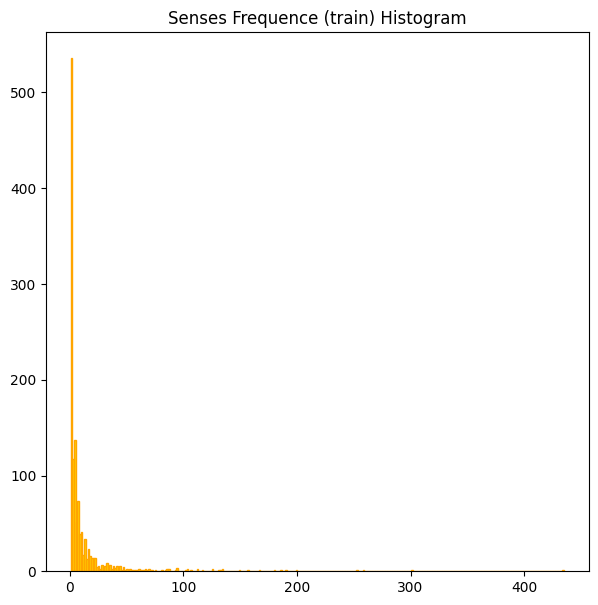

In [84]:
# just want to show the frequence histogram of each coarse-grained sense
senses_frequence_list = list(c.values())
plot_histogram(senses_frequence_list, title="Senses Frequence (train) Histogram")

> This is exactly the **Zipf distribution**: the reason why WSD is not a trivial task at all. It shows us that few senses occur very frequently while the majority of senses occur relatively infrequently! 

It doesn't make much sense to show the least training frequent senses because they are too many, but anyway I'm going to show for the sake of curiosity the least 20 frequent ones.

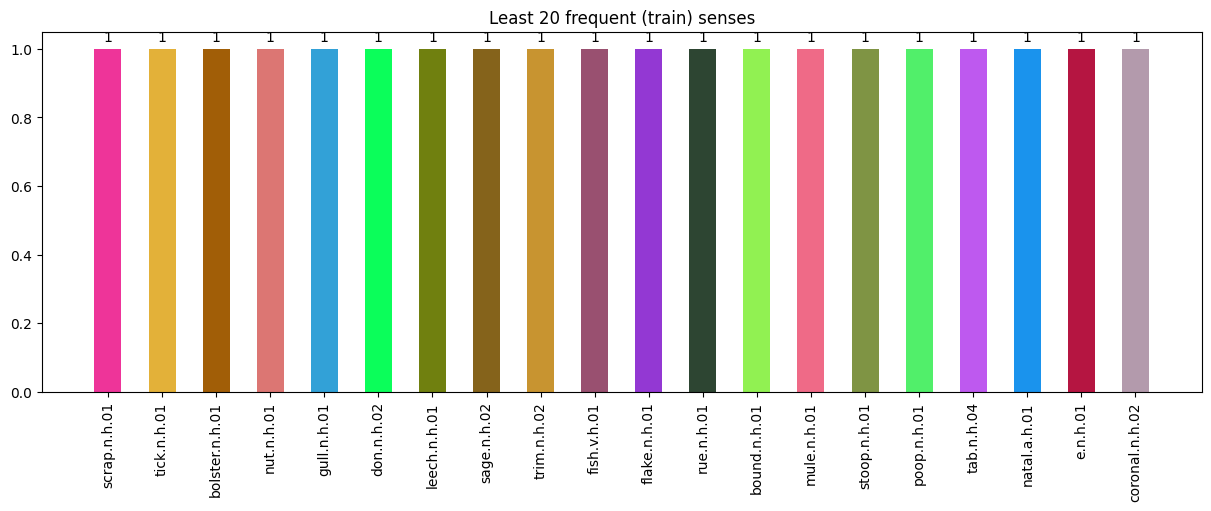

In [98]:
least_common_senses = c.most_common(len(c))[-20:]
columns = [e[0] for e in least_common_senses]
data = [[e[1] for e in least_common_senses]]
title = "Least 20 frequent (train) senses"
one_group_bar(columns, data, title)

### Clean tokens

In [ ]:
# sentence length histogram
from src.utils import read_dataset

train_sentences, _ = read_dataset(hparams["prefix_path"]+hparams["data_train"])
sent_lengths_list = []
for item in train_sentences:
    sent_lengths_list.append(len(item["words"]))
    
plot_histogram(sent_lengths_list)

In [ ]:
# filtering the sentences
from src.utils import read_dataset

train_sentences, _ = read_dataset(hparams["prefix_path"]+hparams["data_train"])
sent_lengths_list = []
tot_sentences, filtered_sentences = 0, 0
for item in train_sentences:
    tot_sentences += 1
    if len(item["words"])< 5 or len(item["words"])> 85:
        filtered_sentences += 1
        continue
    sent_lengths_list.append(len(item["words"]))
plot_histogram(sent_lengths_list)
print(" ______________________________________________________________________________")
print(f"|After the filtering we've lost only the {round((filtered_sentences/tot_sentences)*100,2)}% of  original training sentences!|")
print(" ______________________________________________________________________________")

BUILD THE VOCABULARY SKIPPED PART!!!!!

In [ ]:
# let's see how we are dealing with <UNK> token and how to use or if it is needed a clean_token() function!
data = WSD_DataModule(hparams)
data.setup()

tot_tokens = 0
tot_unk = 0
for batch in tqdm(data.train_dataloader()):
    for input in batch["input"]["input_ids"]:
        for e in input:
            if e.item() == 0:
                break
            tot_tokens+=1
            if e.item() == 100:
                tot_unk+=1
print(f"we have a total of {tot_tokens} tokens")
print(f"with {tot_unk} <UNK> tokens!")

> It's unbelievable how, thanks to the **BERT Tokenizer** (*WordPiece*), we generate zero \<UNK\> tokens! 

we need to do a sanity checks:
- see if all the senses are valid etc.
- see if at least one word to disambiguate is present.
- 

## Look at the data! 👀

In [ ]:
data = []

# TRAIN
c = Counter([e for sublist in [d["labels"] for d in data_train] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

# VAL
c = Counter([e for sublist in [d["labels"] for d in data_val] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

# TEST
c = Counter([e for sublist in [d["labels"] for d in data_test] for e in sublist])
l = list(c.values())
tot = 0
for v in l:
    tot += int(v)
for i in range(len(l)):
    l[i] = (l[i]/tot)*100
data.append(l)

columns = list(c.keys())
three_group_bar(columns, data, "train/val/test Labels Distribution")

As we can see above the three distribution are quite similar and is pretty evident how the "*O*" label is the most dominant one. Hence, we are dealing with an *unbalanced* dataset and in fact all the choices that I've made during the development path of the project were selected to address this problem. <br> The context setting is low and for each sentence there are no many words to help the model to predict the events. For this reason, in my opinion, has been crucial to first **clean the tokens** from any dirtiness and create new and smart ones and secondly to **build a vocabulary** by generating as few *OOV* words as possible because any word is precious in a task like this.

### Clean tokens 🧹

As I 've already said, the dataset wasn't looking too bad, but some *cleaning* operations were needed to achieve better results on the task. <br> The choices made at this step had two different aims: 
* simple *cleaning* of tokens from weird symbols, punctuations, UNICODE characters and so on;
*  *definition* of new tokens with the hope of helping the model to make good predictions based on their position and context.

> 🔸 The function I implemented is "*clean_tokens*" from the *data.py* file and below I'll described the most significant changes that I executed. Of course, this function is applied to all the dataset splits (*train/val/test*).

In [ ]:
# this is simply how you perform the cleaning
train_sentences = [e["tokens"] for e in data_train]
clean_tokens(train_sentences)

🗒 Basic ***clean_tokens*** steps:
*  in the dataset were often present this kind of misprint character sequence ["<", "ref", "name=", "''", "AAIB_8/88", "''", ">"] that I decided to not consider;
* for dealing with situations like the one above, I introduced a new token *\<IGNORE\>* hoping that the system would ignore it at prediction time. I also defined a set of punctuations/symbols to be substituted by this new token;
* besides the fact of mapping the digit numbers from 0 to 10 to their string version ("2" ➡ "two"), I introduced an other new token *\<NUMBER\>* for all the numbers that appeared in the dataset. This choice has been made for treating all the numbers at the same level of contextual importance;
* a subset of punctuations/symbols that constituted a single token (the ones contained as a part of other words were simply deleted) were left untouched and considered as standalone tokens;
* all the tokens were lower-cased, I deleted all the unicode characters (e.g. *\u00f* ), I substituted all the types of brackets to the round ones and all this type of quotes " ` " to this one " ' ". I replaced "&" with "and" and kept the saxon genitive " 's " as a single token. 

### Build Vocabulary

Since we are going to leverage an architecture with the *embedding layer* at the beginning, we need to decide which **word embedding** to use. It's quite clear that by using it the performance of the model will increase. <br> *Word2Vec* was a possible choice but it generated, according to me, too many *OOV* words and *fastText* was maybe the best choice (many people tell so) but dealing with subwords embeddings was not the best idea. I therefore decided to use **GloVe**. I had three options from the Stanford website but at the end I decided to download "***glove.6B.zip***" because is *uncased*, it has a relatively small vocabulary size (*400K*) with respect to other options but big enough for my purposes and it has four different word embedding sizes (50, 100, 200 and 300) for making experiments. 
> *The **300** embedding size will perform better on my models!*

In [ ]:
# download GloVe pretrained embeddings
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip ../../model/glove.6B.zip

So the starting vocabulary will be the one implicitly defined by the GloVe files.

In [ ]:
def build_glove_vocab(glove_file, emb_size=300):
    word2id = OrderedDict()
    id2emb = OrderedDict()
    id = 0
    for l in open(glove_file, "r"):
        line = l.split(" ")
        word = line[0]
        emb = np.asarray(line[1:], dtype="float64")
        word2id[word] = id
        id2emb[id] = emb
        id += 1
    return word2id, id2emb

In [ ]:
glove_file = "model/glove/glove.6B.300d.txt"
word2id, id2emb = build_glove_vocab(glove_file)

> Since I introduced two new tokens ***\<IGNORE\>*** and ***\<NUMBER\>*** and I don't want to lose any information that can be used to benefit events prediction, I need to extend the vocabulary. I first have to select the most frequent words which are in my training set but not in the vocabulary and then add them to it.

In [ ]:
# list of training OOV words
oov_list = []
for token in [e for sublist in [e["tokens"] for e in data_train] for e in sublist]:
    if token not in word2id and token not in oov_list:
        oov_list.append(token)

# count the frequencies of each OOV word
c = Counter([e for sublist in [e["tokens"] for e in data_train] for e in sublist if e in oov_list])
# show the 100 most common ones
c.most_common(100)

# as a design choice I decide to pick only the train OOV words which have a frequency higher or equal than 10!
words_to_add = []
for e in c.most_common(100):
    if e[1] >= 10:
        words_to_add.append(e[0])

In [ ]:
def build_extended_vocab(glove_file, words_to_add, emb_size=300):
    word2id = OrderedDict()
    id2emb = OrderedDict()
    tot, numbers_tot = np.zeros(emb_size, dtype="float64"), np.zeros(emb_size, dtype="float64")
    id, num = 0, 0
    for l in open(glove_file, "r"):
        line = l.split(" ")
        word = line[0]
        emb = np.asarray(line[1:], dtype="float64")
        if word.isnumeric():
            numbers_tot += emb
            num += 1
        word2id[word] = id
        id2emb[id] = emb
        tot += emb
        id += 1
    
    for w in words_to_add:
        word2id[w] = id
        if w=="<NUMBER>":
            emb = numbers_tot/num # average of all the numbers embeddings
            id2emb[id] = emb
            tot += emb
        else:
            emb = np.random.rand(emb_size) # random initialization of the embedding
            id2emb[id] = emb
            tot += emb
        id += 1

    word2id['<UNK>'] = id
    id2emb[id] = tot/id # average of the other embeddings
    word2id['<PAD>'] = id+1
    id2emb[id+1] = np.zeros(emb_size, dtype="float64")
    return word2id, id2emb

In [ ]:
glove_file = "model/glove/glove.6B.300d.txt"
word2id, id2emb = build_extended_vocab(glove_file, words_to_add)

In [ ]:
# if not already there, you can save the vocabulary in "model/files/vocabs" as "word2id.json"
json.dump(word2id, open("model/files/vocabs/word2id.json", "w"))

# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer.pth"
embedding_layer = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb.values()))))
torch.save(embedding_layer.state_dict(), "model/embeddings/300/embedding_layer.pth")

> 🔸 To check the goodness of my extended vocabulary and of the previous token cleaning process, I want to check if there are labeled *EVENTS* that are not present in the vocabulary (*OOV events*). If so, I'll intervene in some way.

In [ ]:
for sample in data_train:
    for i in range(len(sample["tokens"])):
        if sample["labels"][i] != "O" and sample["tokens"][i] not in word2id:
            print("OOV event detected!")
# it doesn't print anything, so we're OK!

> ⚡ **Embeddings strategy**: given that the "GloVe" embeddings are already pretrained and instead the new words that I added to the extended version of it are randomly initialized, it made sense to me to differentiate their training behaviour. In fact, if the *hyperparameter* ***num_emb*** is set to 2, we have the option to stop the finetuning process of the pretrained GloVe embeddings after **stop_train_emb** epochs while  continuing the training of the "added" embeddings. For this purpose, in practice, we have to "split" the vocabulary and create two separate embedding layers.


In [ ]:
## GloVe embeddings
id2emb_1 = {k:v for k,v in id2emb.items() if k<400000}
# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer_1.pth"
embedding_layer_1 = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb_1.values()))))
torch.save(embedding_layer_1.state_dict(), "model/embeddings/300/embedding_layer_1.pth")

## new added embeddings
id2emb_2 = {str(int(k)-400000):v for k,v in id2emb.items() if k>=400000}
# if not already done, you can save the embedding layer in "model/embeddings/300" as "embedding_layer_2.pth"
embedding_layer_2 = torch.nn.Embedding.from_pretrained(torch.from_numpy(np.vstack(list(id2emb_2.values()))))
torch.save(embedding_layer_2.state_dict(), "model/embeddings/300/embedding_layer_2.pth")

### Filter Sentences 🥅

Another important step before finishing the preprocessing part, is to filter out the *training* sentences. This is something it has to be done only at training time because the test/val datasets don't have to be touched in this sense. <br> Let's first see which is the histogram of sentences length.

In [ ]:
sent_lengths_list = [len(e) for e in train_sentences]
plot_histogram(sent_lengths_list)

As we can see there are some "sentence *outliers*" which deviates from the majority of data and this is not good in machine learning because our aim is always to learn a data distribution. Actually the mean value is 25, but we have the maximum sentence length that reaches 343. This kind of training samples have to be avoided in order to not make the model learn other type of distribution. <br> Saying that, the first step to do is to filter sentences based on their length. I've choosen to set *min_sent_length=2* and *max_sent_length=60* as length bounds and they appeared to work pretty good. Other type of sentences that I wanted to delete from the train set, as not useful for the prediction process, were the ones with no "*EVENTS*", i.e. labels with all "*O*".

In [ ]:
train_sentences, train_labels = filter_sentences([e["tokens"] for e in data_train], [e["labels"] for e in data_train], word2id)
sent_lengths_list = [len(e) for e in train_sentences]
plot_histogram(sent_lengths_list)

> 🔸 Look now how good the shape is looking! Only *9%* of sentences are excluded (1778 sentences). The function I implemented to do this filtering is "*filter_sentences*" from the *data.py* file and is only applied to *training* data.

## Models

The adviced model architecture is a simple composition of an **Embedding layer**, a **Sequence encoder** and at the end a **Classifier**. <br> What I've implemented for this homework:
* *nn.Embedding* pytorch module to work as a lookup table with pretrained GloVe embeddings and additional embeddings. Possibility of split the embeddings to have two different ways of being trained.
* *nn.LSTM* pytorch architecture was the immediate choice. I didn't try other *RNNs-like* architectures as *GRU* for example because honestly since the beginning I achieved good results and therefore I decided to focus on *hyperparameters tuning* (using *Sweep* feature of  WandB). Without *LSTM*, it would have been impossible to encode information about the context of words (basic for our task) and it's probably the main block of the model. With respect to *vanilla RNNs*, it overcomes the vanishing gradient problem and it most robust to long term dependencies between words. One of its greatest power is the possibility of encoding the sequence both from *left-to-right* and *from right-to-left* to further enhance contextualization (***Bi-LSTMS***). To increase the performance I played and tweaked with *hidden_dim*, *bidirectional* and *num_layers* hyperparameter values.
* *nn.Linear* is the simplest classifier to use. I also implemented a *MLP classifier* with three layers and ReLu activation functions, but with poor results. Therefore I used the simplest version which performed better and has moreover less weights to train.

### ⚡ EXTRAS 

During the very first experiments I noticed that for the system was especially hard to predict correctly the "*inside*" tags. Reasoning about it, this can be due  to the scarcity of these type of labels. In fact, with  respect to the "*begin*" tags, they are really a lot fewer (see the first plot of labels distribution). But anyway, I approach this issue and tried to solve it. 

* The first idea was to sum to the word embeddings, as it happens in *Transformer* models, a **positional encoding**. In order to convey to the model a sort of knowledge about where the tokens are within the sequence. For example if the prediction is "*B-ACTION*" at position *i*, the system should understand that the probability that "I-ACTION" is at *i+1* is higher than position *i-1*. It didn't work as expected: maybe because the positional encoding expresses its full potential in the moment in which *attention* in involved. 
* The second idea was to leverage **POS tags**. This because I noticed that most of the time the *events* are verbs (VERB) and I thought that giving the model an information like this it would have helped it. However I think that giving POS tags is in general benefitting the overall system since it can learn or extrapolate underlying grammatical relations which I could never have noticed. *How to provide/combine them with the model?* I tried and thought many options but at the end the most intuitive one is the following: after computing the POS tags of the input sequence, I embed it in a simply *Embedding layer*, I then sum the result to the *LSTM output* and finally feed it to a *Linear layer* which learns to compute the best way (hopefully) of combining them. 

### Baseline

<br>
<table>
  <tr>
    <th><center>hparams</center></th>
    <th><center> </center></th>
  </tr>
  <tr>
    <td><center>load_pretrained_emb</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>hidden_dim</center></td>
    <td><center>512</center></td>
  </tr>
    <tr>
    <td><center>bidirectional</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>num_layers</center></td>
    <td><center>1</center></td>
  </tr>
   <tr>
    <td><center>dropout</center></td>
    <td><center>0</center></td>
  </tr>
    <tr>
    <td><center>⚡ POS_emb</center></td>
    <td><center>False</center></td>
  </tr>
    <tr>
    <td><center>⚡ positional_encode</center></td>
    <td><center>False</center></td>
  </tr>
 

</table>
<br>

## Dataset

## Training ⛏

> Throughout all the project I used ***WandB*** as logging tool.

In [ ]:
def training_pipeline(config=None):
    hparams_tuning = False
    version_name = "bert_silu_drop_0.6_sum"
    with wandb.init(entity="lavallone", project="NLP", name=version_name, mode="online", config=config):
        seed = wandb.config.seed if hparams_tuning else 1999
        set_seed(seed)
        hparams = asdict(Hparams())
        # when doing the hparams search, this is how each run we change them to search for the best combinations!
        if hparams_tuning:
            hparams["batch_size"] = wandb.config.batch_size
            hparams["dropout"] = wandb.config.dropout
            hparams["lr"] = wandb.config.lr
            hparams["hidden_dim"] = wandb.config.hidden_dim
            hparams["seed"] = wandb.config.seed

        data = WSD_DataModule(hparams)
        model = WSD_Model(hparams)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)
        
        train_model(data, model, experiment_name=version_name, patience=5, metric_to_monitor="val_loss", mode="min", epochs=100, precision=hparams["precision"])

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85
training_pipeline()
wandb.finish()

### Hyperparameters tuning

> *WandB* provides a very user-friendly and easy-to-use *automated hyperparameter search* tool called ***Sweep***. This is how I tuned my hyperparameters. It can be noticed that I wanted to search also for the *random seed generator* both for "picking" the most convenient network's weights initialization and for selecting the "best" training dataloaders combination when using the *mixing windows strategy*. 

In [ ]:
wandb.login() # this is the key to paste each time for login: 65a23b5182ca8ce3eb72530af592cf3bfa19de85

sweep_config = {'method': 'random',
                'metric': {'goal': 'maximize', 'name': 'val_macro_f1', 'target' : 0.73},
                'parameters': {
                                'batch_size': {'values': [64, 128, 256, 512]},
                                'dropout': {'distribution': 'uniform', 'min': 0.3, 'max': 0.5},
                                'emb_dim': {'values': [50, 100, 200, 300]},
                                'lr': {'distribution': 'uniform', 'min': 1e-4, 'max': 1e-2},
                                'num_layers': {'distribution': 'int_uniform', 'min': 1, 'max': 5},
                                'hidden_dim': {'distribution': 'int_uniform', 'min': 200, 'max': 600},
                                'seed': {'distribution': 'int_uniform', 'min': 1, 'max': 1000},
                            }
               }

sweep_id = wandb.sweep(sweep=sweep_config, project="NLP", entity="lavallone")
wandb.agent(sweep_id, function=training_pipeline, count=40)
wandb.finish()

## Evaluation

> I also implemented an *evaluation pipeline* to avoid to execute each time the provided *test.sh* shell script. In fact it uses *docker* 🐳, which consumes a lot of storage space each run. Of course I'll use it for the final evaluation of my best model.

In [ ]:
# TEST
best_ckpt = "../../model/checkpoints/bert_relu_drop_0.6_batch_128-epoch=22-val_micro_f1=0.8730.ckpt"
model = WSD_Model.load_from_checkpoint(best_ckpt, strict=False, device="cuda" if torch.cuda.is_available() else "cpu")
data = WSD_DataModule(model.hparams)
data.setup()

additional_infos = False
if additional_infos:
    classification_report = evaluation_pipeline(model, data, additional_infos=additional_infos)
else:
    evaluation_pipeline(model, data)